In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

from scipy.optimize import curve_fit
from scipy.stats import chi2

In [2]:
from matplotlib import rc
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
rc('font', **font)

In [3]:
root = Path(os.getcwd())
dp = root / "Data"

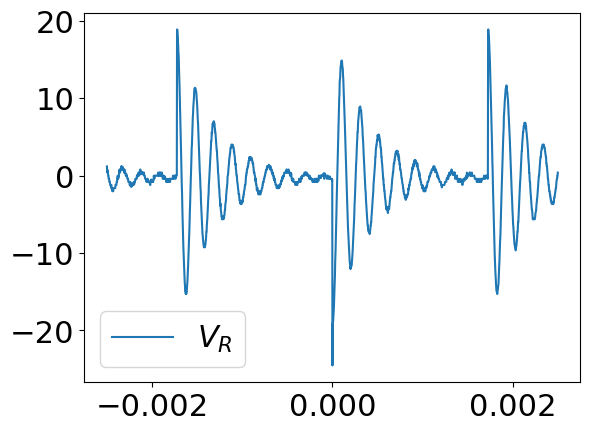

In [4]:
fp = dp / "e2_lc_t2_Vl.csv"

ds = np.genfromtxt(fp, delimiter=",")

d = np.where(ds == np.nan, 0, ds)
d = np.transpose(d)
plt.plot(d[0], d[1], label=r"$V_R$")
# plt.plot(d[0], d[2], label=r"$V_C$")

plt.legend()

# Experiment 3

In [5]:
from utils import plotpath

3.4005


In [6]:
def dual_plotter(x, y1, y2, xname="", y1name="", y2name="", name=""):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(f'{xname}')
    ax1.set_ylabel(f'{y1name}', color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(f'{y2name}', color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    if name != "":
        plt.savefig(plotpath / name, bbox_inches="tight")
    plt.show()

In [7]:
# # Empiral Constants 

# ## TODO: Find Uncertainties off Keysight DSOX1202G oscope
Remp = 520.1
V0pp = 12.0

# ## TODO: Find uncertanties off Meterman 37XR 
Lemp = 0.0255
Cemp = 23.15e-9

In [8]:
def plot_residuals(x, y, y_fit, y_unc, xlabel="", ylabel="Residuals", save_as=""):
    residuals = y - y_fit
    plt.errorbar(x, residuals, yerr=y_unc, fmt='o', ecolor='lightgray', elinewidth=2, capsize=1)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_as:
        plt.savefig(plotpath / save_as, bbox_inches="tight")
    plt.show()

def calculate_chi2(y, y_fit, y_unc, k):
    """
    Calculate the chi-squared statistic, reduced chi-squared, and chi-squared probability.
    Parameters:
    y (array-like): Observed data points.
    y_fit (array-like): Fitted data points.
    y_unc (array-like): Uncertainties in the observed data points.
    k (int): Number of fitted parameters.
    Returns:
    tuple: A tuple containing:
        - chi (float): The chi-squared statistic.
        - reduced_chi2 (float): The reduced chi-squared statistic.
        - chi2_prob (float): The probability of obtaining a chi-squared value at least as extreme as the one computed, given the degrees of freedom.
    """

    chi = np.sum(((y - y_fit) / y_unc) ** 2)
    dof = len(y) - k
    reduced_chi2 = chi / dof
    chi2_prob = 1 - chi2.cdf(chi, dof)
    return chi, reduced_chi2, chi2_prob

## RC Circuit

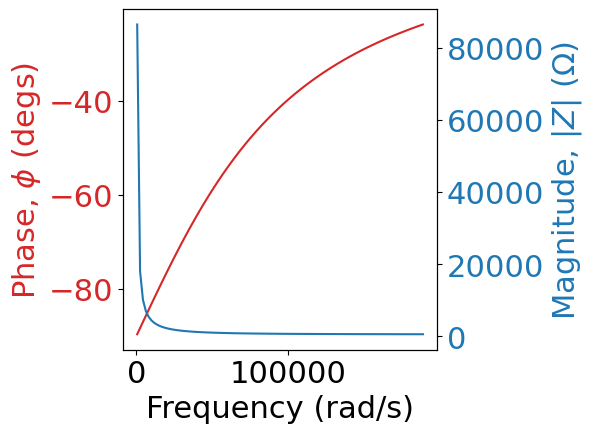

In [9]:
# Theoretical Curves 

# Z = R - j/wC 
Rc = Remp
C = Cemp 

omegas = np.linspace(500, 2 * np.pi * 30e3, 100)
Zmag = np.sqrt(Rc**2 + (1 / (omegas * C))**2)
Zphas  = np.arctan(-1/(omegas * C * Rc)) * 180/np.pi

# Theoretical Curves 

# fig, ax1 = plt.subplots()

fname = 'Frequency (rad/s)'
y1name = r'Phase, $\phi$ (degs)'
y2name = r'Magnitude, $|Z|$ ($\Omega$)'

dual_plotter(omegas, Zphas, Zmag, fname, y1name, y2name, "e3_rc_theory")


<ErrorbarContainer object of 3 artists>

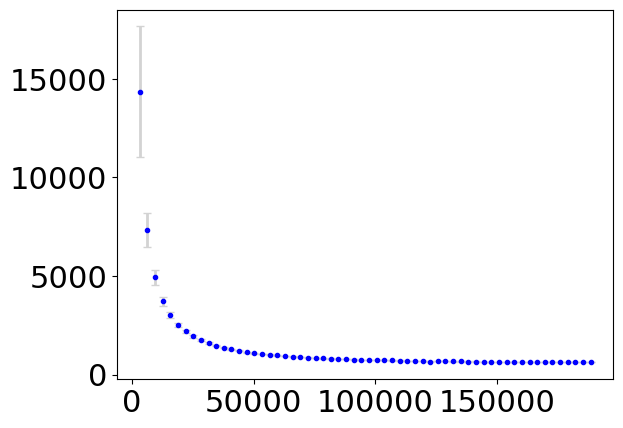

In [10]:
fp = dp / "e3_rc_t1.csv"

ds = np.genfromtxt(fp, delimiter=",")

d = np.where(ds == np.nan, 0, ds)
d = d[~np.isnan(d).any(axis=1)]  # Remove rows with NaN values
d = d[d[:, 0].argsort()]  # Sort by the first element of each row
d = np.transpose(d)

freqs = 1000 * d[0] * 2 * np.pi
Zrc_phas = d[1]
Zrc_phas_unc = 0.5 * np.ones_like(Zrc_phas)
Zrc_mag = V0pp * Remp/d[2]

V0pp_unc = 0.1
d2_unc = 0.1
Remp_unc = 0.3

Zrc_mag_unc = Zrc_mag * np.sqrt((V0pp_unc / V0pp)**2 + (Remp_unc / Remp)**2 + (d2_unc / d[2])**2)

# dual_plotter(freqs, Zrc_phas, Zrc_mag, fname, y1name, y2name)


plt.errorbar(freqs, Zrc_mag, yerr=Zrc_mag_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)

In [11]:
def rc_fit(x, C):
    return np.arctan(-1/(x * 520.1 * C)) * 180/np.pi

[2.15173057e-08]
[5.76373437e-11]


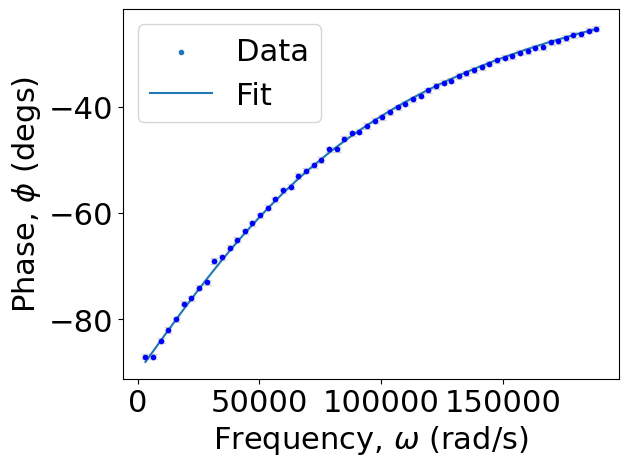

In [12]:
popt_rc, pcov_rc = curve_fit(rc_fit, freqs, Zrc_phas, p0=( 22e-9), sigma=Zrc_phas_unc, absolute_sigma=True)

perr_rc = np.sqrt(np.diag(pcov_rc))
print(popt_rc)
print(perr_rc)
fs = np.linspace(freqs[0], freqs[-1], 1000)
yfit = rc_fit(fs, *popt_rc)

plt.scatter(freqs, Zrc_phas, marker='.', label="Data")
plt.errorbar(freqs, Zrc_phas, yerr=Zrc_phas_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)
plt.plot(fs, yfit, label="Fit")
xlab = r"Frequency, $\omega$ (rad/s)"
plt.xlabel(xlab)
plt.ylabel(y1name)
plt.legend()
plt.savefig(plotpath / "e3_rc_phase", bbox_inches="tight")
plt.show()

In [13]:
def rc_magfit(x, R):
    return np.sqrt(R**2 + (1/(x * popt_rc[0])**2))

[568.87324622]
[1.76081728]


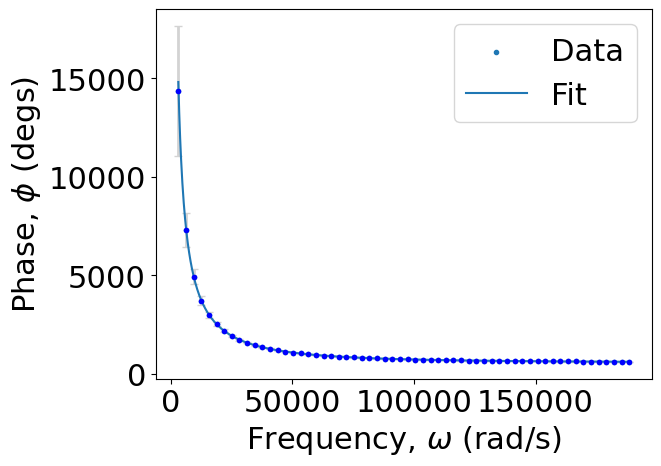

In [14]:
popt_rcm, pcov_rcm = curve_fit(rc_magfit, freqs, Zrc_mag, p0=(500), sigma=Zrc_mag_unc, absolute_sigma=True)

perr_rc = np.sqrt(np.diag(pcov_rcm))
print(popt_rcm)
print(perr_rc)
fs = np.linspace(freqs[0], freqs[-1], 1000)
yfit = rc_magfit(fs, *popt_rcm)

plt.scatter(freqs, Zrc_mag, marker='.', label="Data")
plt.errorbar(freqs, Zrc_mag, yerr=Zrc_mag_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)
plt.plot(fs, yfit, label="Fit")
xlab = r"Frequency, $\omega$ (rad/s)"
plt.xlabel(xlab)
plt.ylabel(y1name)
plt.legend()
plt.savefig(plotpath / "e3_rc_data", bbox_inches="tight")
plt.show()

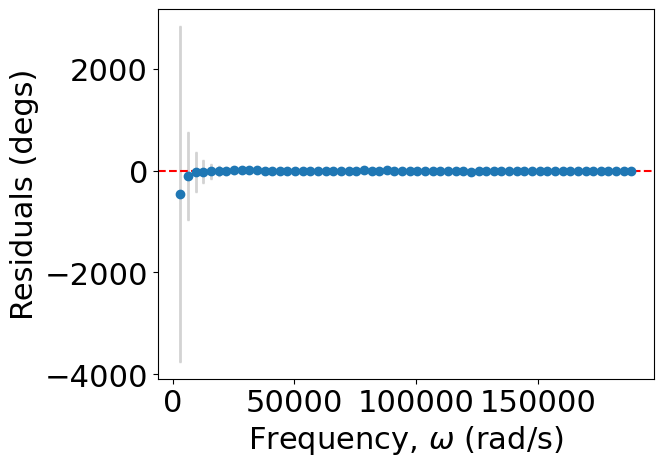

In [15]:
yrcm_fit = rc_magfit(freqs, *popt_rcm)
plot_residuals(freqs, Zrc_mag, yrcm_fit, Zrc_mag_unc, xlabel=xlab, ylabel="Residuals (degs)")

In [16]:
calculate_chi2(Zrc_mag, yrcm_fit, Zrc_mag_unc, len(popt_rcm))

(np.float64(7.740807332449865),
 np.float64(0.13120012427881128),
 np.float64(0.9999999999999999))

In [17]:
from utils import format_parameters_with_errors
format_parameters_with_errors(popt_rc, perr_rc)

['0.0 ± 2.0']

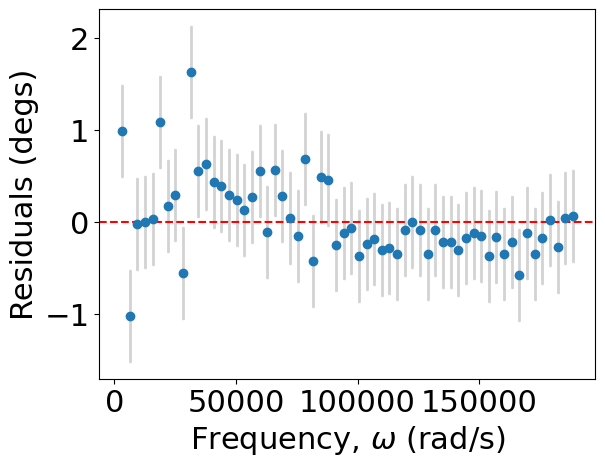

In [18]:
yrc_fit = rc_fit(freqs, *popt_rc)
plot_residuals(freqs, Zrc_phas, yrc_fit, Zrc_phas_unc, xlabel=xlab, ylabel="Residuals (degs)", save_as="e3_rc_phase_res")

In [19]:
calculate_chi2(Zrc_phas, yrc_fit, Zrc_phas_unc, len(popt_rc))

(np.float64(45.36374742895871),
 np.float64(0.7688770750670968),
 np.float64(0.9040405391273615))

## LR Circuit

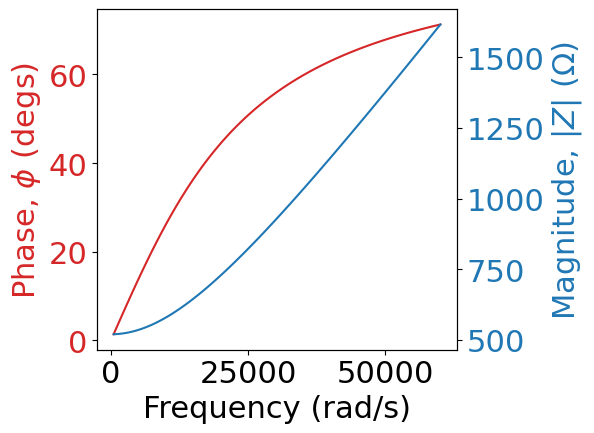

In [20]:
# Theoretical Curves 

ws = np.linspace(500, 60000, 100)
L = Lemp
phis = np.arctan(ws * L/Rc) * 180/np.pi 
lmags = np.sqrt(Rc**2 + (ws * L)**2)

dual_plotter(ws, phis, lmags, fname, y1name, y2name, "e3_rl_theory")

<ErrorbarContainer object of 3 artists>

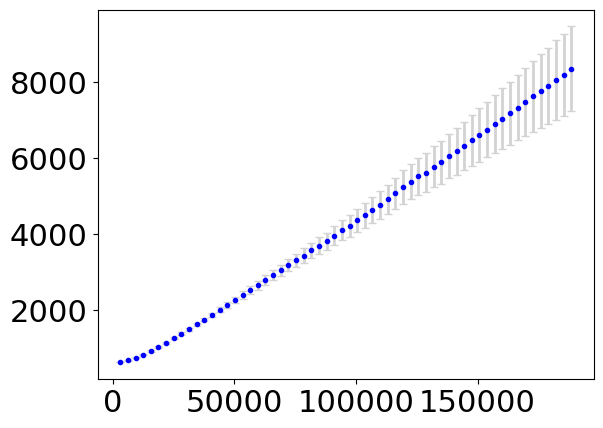

In [21]:
fp = dp / "e3_lr_t1.csv"

ds = np.genfromtxt(fp, delimiter=",")

d = np.where(ds == np.nan, 0, ds)
d = d[~np.isnan(d).any(axis=1)]  # Remove rows with NaN values
d = d[d[:, 0].argsort()]  # Sort by the first element of each row
d = np.transpose(d)

freqs = 1000 * d[0] * 2 * np.pi 
Zlr_phas = d[1] 
Zlr_phas_unc = 0.5 * np.ones_like(Zlr_phas)
Zlr_mags = V0pp/d[2] * Remp 

V0pp_unc = 0.1
d2_unc = 0.1
Remp_unc = 0.3

Zlr_mag_unc = Zlr_mags * np.sqrt((V0pp_unc / V0pp)**2 + (Remp_unc / Remp)**2 + (d2_unc / d[2])**2)

# dual_plotter(freqs, Zlr_phas, Zlr_mags, fname, y1name, y2name)

plt.errorbar(freqs, Zlr_mags, yerr=Zlr_mag_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)

In [22]:
def rl_fit(x, L):
    return np.arctan(x * L/(Remp)) * 180/np.pi 

[0.04113874]
[0.00021104]


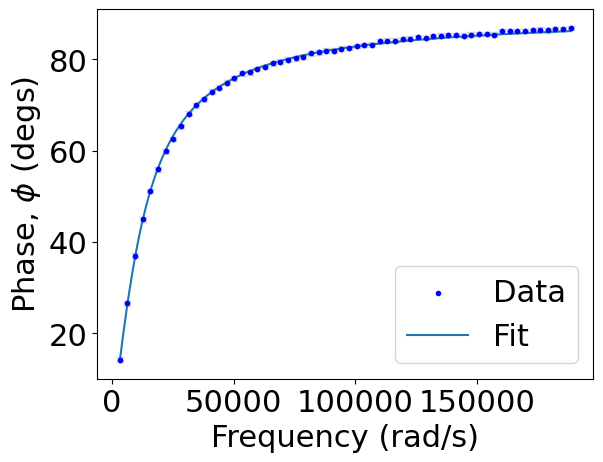

In [23]:
popt_rl, pcov_rl = curve_fit(rl_fit, freqs, Zlr_phas, p0=(0.0255), sigma=Zlr_phas_unc, absolute_sigma=True)

perr_rl = np.sqrt(np.diag(pcov_rl))
print(popt_rl)
print(perr_rl)
fs = np.linspace(freqs[0], freqs[-1], 1000)
yfit = rl_fit(fs, *popt_rl)

plt.scatter(freqs, Zlr_phas, marker='.', label="Data", color='blue')
plt.errorbar(freqs, Zlr_phas, yerr=Zlr_phas_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)
plt.plot(fs, yfit, label="Fit")
plt.xlabel(fname)
plt.ylabel(y1name)
plt.legend()
plt.savefig(plotpath / "e3_rl_phase", bbox_inches="tight")
plt.show()

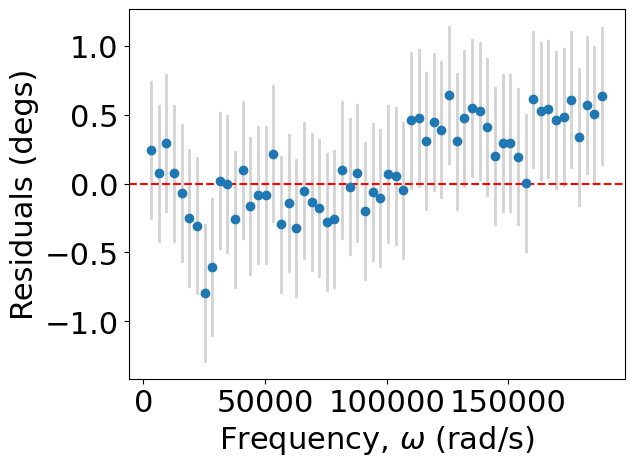

In [24]:
ylr_fit = rl_fit(freqs, *popt_rl)
plot_residuals(freqs, Zlr_phas, ylr_fit, Zlr_phas_unc, xlab, "Residuals (degs)", save_as="e3_rl_phase_res")

In [25]:
calculate_chi2(Zlr_phas, ylr_fit, Zlr_phas_unc, len(popt_rl))

(np.float64(29.808866901814287),
 np.float64(0.5052350322341405),
 np.float64(0.9994540780042918))

In [26]:
def lr_magfit(x, L):
    return np.sqrt(Remp**2 + (x * L)**2)

[0.04530777]
[0.00028603]


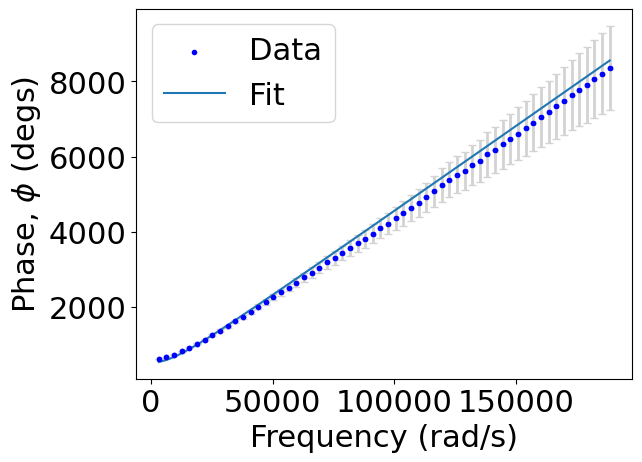

In [27]:
popt_rlm, pcov_rlm = curve_fit(lr_magfit, freqs, Zlr_mags, p0=(0.0255), sigma=Zlr_mag_unc, absolute_sigma=True)

perr_rl = np.sqrt(np.diag(pcov_rlm))
print(popt_rlm)
print(perr_rl)
fs = np.linspace(freqs[0], freqs[-1], 1000)
yfit = lr_magfit(fs, *popt_rlm)

plt.scatter(freqs, Zlr_mags, marker='.', label="Data", color='blue')
plt.errorbar(freqs, Zlr_mags, yerr=Zlr_mag_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)
plt.plot(fs, yfit, label="Fit")
plt.xlabel(fname)
plt.ylabel(y1name)
plt.legend()
plt.show()

In [28]:
C_empfit = popt_rc[0]
L_empfit = popt_rl[0]
print(C_empfit, L_empfit)

2.1517305711684704e-08 0.04113874106238695


## LCR Circuit

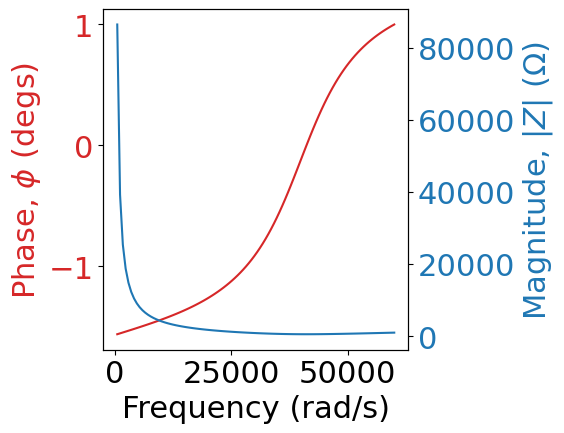

In [29]:
Rc = Remp
L = Lemp
omegas = np.linspace(500, 60000, 100)

Zmag = np.sqrt(Rc**2 + (omegas * L - 1 / (omegas * C))**2)  # Correct impedance magnitude
Zphas  = np.arctan((omegas * L - 1/(omegas * C))/Rc)

# Theoretical Curves 
# fig, ax1 = plt.subplots()

dual_plotter(omegas, Zphas, Zmag, fname, y1name, y2name, "e3_lcr_theory")

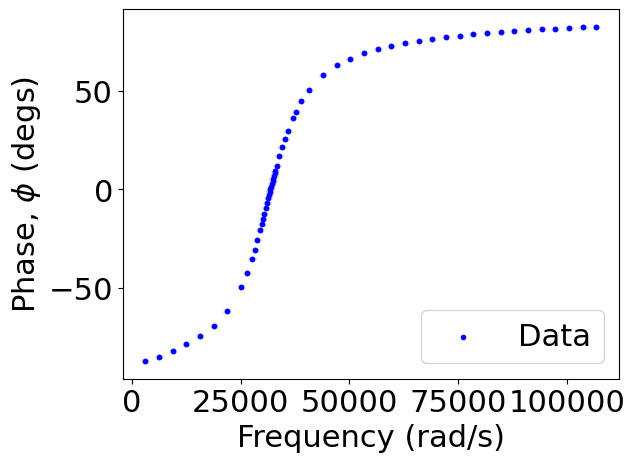

In [30]:
fp = dp / "e3_lcr_t1.csv"

ds = np.genfromtxt(fp, delimiter=",")

d = np.where(ds == np.nan, 0, ds)
d = d[~np.isnan(d).any(axis=1)]  # Remove rows with NaN values
d = d[d[:, 0].argsort()]  # Sort by the first element of each row
d = np.transpose(d)

freqs = 1000 * d[0] * 2 * np.pi
Zlr_phas = d[1]
Zlr_phas_unc = 0.5 * np.ones_like(Zlr_phas)
Zlr_mags = V0pp/d[2] * Remp     
plt.scatter(freqs, Zlr_phas, marker='.', label="Data", color='blue')
plt.errorbar(freqs, Zlr_phas, yerr=Zlr_phas_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)
plt.xlabel(fname)
plt.ylabel(y1name)
plt.legend()
plt.show()
# plt.errorbar(freqs, Zlr_phas, yerr=Zlr_phas_unc, marker='.', label="Data")
# dual_plotter(freqs, Zlr_phas, Zlr_mags, fname, y1name, y2name)

In [31]:
def lcr_phase_fit(x, C, L):
    num = x * L - 1/(x * (C))
    return np.arctan(num/(Remp)) * 180/np.pi

[2.46422160e-08 3.99050615e-02]
[1.00102143e-10 1.60430647e-04]


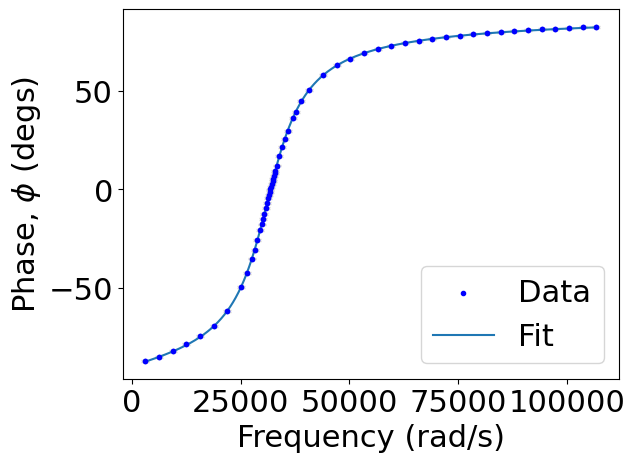

In [32]:
popt_rlc, pcov_rlc = curve_fit(lcr_phase_fit, freqs, Zlr_phas, p0=( 22.5e-9, 0.0255), sigma=Zlr_phas_unc, absolute_sigma=True)

print(popt_rlc)
perr_rlc = np.sqrt(np.diag(pcov_rlc))
print(perr_rlc)
fs = np.linspace(freqs[0], freqs[-1], 1000)
yfit = lcr_phase_fit(fs, *popt_rlc)

plt.scatter(freqs, Zlr_phas, marker='.', label="Data", color='blue')
plt.errorbar(freqs, Zlr_phas, yerr=Zlr_phas_unc, fmt='.', color='blue', ecolor='lightgray', elinewidth=2, capsize=3)
plt.plot(fs, yfit, label="Fit")
plt.xlabel(fname)
plt.ylabel(y1name)
plt.legend()
plt.show()

In [33]:
format_parameters_with_errors(popt_rlc, perr_rlc)

['2.46e-08 ± 1e-10', '0.0399 ± 0.0002']

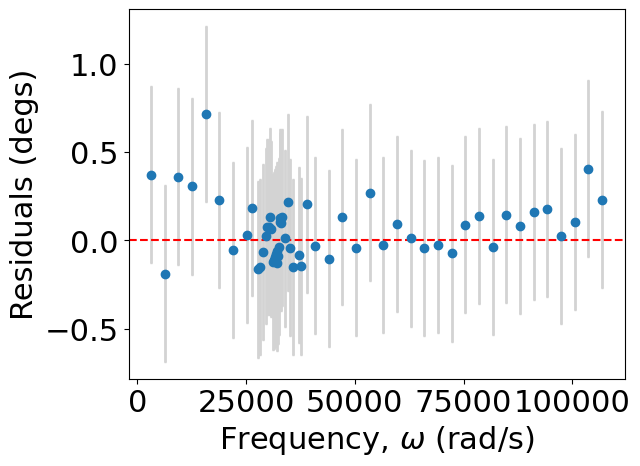

In [36]:
ylrc_fit = lcr_phase_fit(freqs, *popt_rlc)
plot_residuals(freqs, Zlr_phas, ylrc_fit, Zlr_phas_unc, xlab, "Residuals (degs)", save_as="e3_lrc_phase_res")

In [35]:
calculate_chi2(Zlr_phas, ylrc_fit, Zlr_phas_unc, len(popt_rlc))

(np.float64(7.301977899916524),
 np.float64(0.128104875437132),
 np.float64(0.9999999999999998))